# Project Report: bci4als
#### Authors: Evyatar Luvaton, Noam Siegel

This software was developed for the course Brain-Computer-Interface for ALS Patients, December 2020.

Over the mid-semester project we have integrated the different parts of BCI which been discussed in the course.
We introduce bci4als, a complete pipeline for EEG motor imagery data recording and classification.


The pipeline is general, so it can be extended to other BCI settings like P300, SSVEP.

The first part of this report presents the python package bci4als.


## Preliminaries

First, go ahead and install bci4als (if you haven't already done so).

```{python}
pip install -i https://test.pypi.org/simple/ bci4als;
```


<B>Project Structure</B>

Structure your project exactly as shown:

In [24]:
print(open('project_structure_0.txt', 'r', encoding='utf-8').read())

project_name
├── data
│   ├── subject1
│   └── subject2
└── main.py



The main codebase lies in the `bci4als.mi` module:

In [36]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import mne
import pickle
import bci4als.mi as mi
import pandas as pd
import seaborn as sns

## Part 1 - End-to-End Walkthrough

We will now guide you how to use the `bci4als` pipeline from end to end.


<B>Note:</B>
All the scripts share common configuration parameters, which are stored in a multi-level `dict` object called `mi.params`. The first-layer keys indicate the category of parameters:

In [ ]:
params = mi.params
params.keys()

For example, to see the parameters related to preprocessing:

In [ ]:
preprocess_params = params['preprocess']
print('\n'.join('{}: {}'.format(k, v) for k, v in preprocess_params.items()))

### step 1 - record experiment
the `bci4als.mi.record` module is responsible for executing a motor imagery experiment and recording the stimulus.

the `bci4als.mi.record.start()` function starts an interactive gui which will guide you through executing a mi experiment. it assumes you:

1) have an external application streaming eeg data (via lsl) to lab recorder.

2) have a `currentstudy` directory into which the collected data will be saved.

3) opened `labrecorder`.

once you are ready, begin recording:

```{python}
mi.record.start()
```

Now follow the following steps:

1) You should see a "Welcome" messagebox. Press "OK" to continue.

2) Select the CurrentStudy folder.

3) Type a new Session ID (this will be the name of the folder). Press "OK" to continue.

4) You should a confirmation messagebox. Press "OK" to continue.

5) Point the LabRecorder to the folder created at step 3. Set the name of the file EEG.xdf

6) <B> Make sure you are prepared to begin the motor imagery experiment. </B>Press "OK" to begin the trials.

7) After the experiment, press "OK" to close the program.


Lab Recorder will generate the `EEG.xdf` file which contains the EEG and markers recording. It can be read with pyxdf.

Python will generate `stimulus_vector.csv`, which contains the labels for each trial.

Your project structure should look like this:

In [27]:
print(open('project_structure_1.txt', 'r', encoding='utf-8').read())

project_name
├── data
│   ├── subject1
│   └── subject2
│          └── session1
│               ├── EEG.xdf
│               └── stimulus_vectors.csv
└── main.py



### Step 2 - Data Preprocessing

The `preprocess.py` script is responsible for cleaning the data.

Currently, the pre-processing script uses low-pass, high-pass and notch filters to clean the data.

The parameters for the filters are also part of the `params` object:

In [29]:
params['preprocess']['filter']

{'high_pass': 0.5, 'low_pass': 70, 'notch': 50}



The script will output an `EEG_clean.csv` file, which contains the EEG data
after the pre-processing. Additionally, the script exports a `.info` json file. The `.info` file
contains all the info about the EEG stream.

Your project structure should now look like this:

In [28]:
print(open('project_structure_2.txt', 'r', encoding='utf-8').read())



project_name
├── data
│   ├── subject1
│   └── subject2
│          └── session1
│               ├── EEG.xdf
│               └── stimulus_vectors.csv
│               ├── EEG_clean.csv
│               └── .info
└── main.py



Let's plot the clean EEG data:

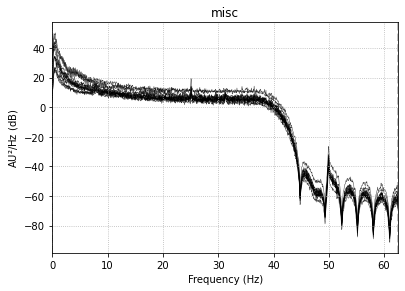

In [30]:
# Params
eeg_clean_path = '../data/noam/2/EEG_clean.csv'
ch_names = ['C03', 'C04', 'P07', 'P089', 'O01', 'O02', 'F07', 'F08', 'F03', 'F04', 'T07', 'T08', 'P03']
s_rate = 125

# Create mne info & raw
eeg_clean = np.genfromtxt(eeg_clean_path, delimiter=',', skip_header=1)[:, 1:]
info = mne.create_info(ch_names, s_rate, verbose=False)
raw_eeg_clean = mne.io.RawArray(eeg_clean.T, info, verbose=False)

# Plot
fig = raw_eeg_clean.plot_psd(picks=ch_names, show=False)

### Step 3 - Data Segmentation

In the `segment_data.py` script we split the data for each trial.
The start and end of each trial is according to the markers streaming we created
while recording the EEG. The script gets the subject folder from the config file
(under `config['data']['subject_folder']`) and splits for trial each
EEG record in each day.

The output of MI3 script is a pickle file named `EEG_trials.pickle` which
located in the corresponded day directory.
Your project structure should now look like this:

In [33]:
print(open('project_structure_3.txt', 'r', encoding='utf-8').read())


project_name
├── data
│   ├── subject1
│   └── subject2
│          └── session1
│               ├── EEG.xdf
│               └── stimulus_vectors.csv
│               ├── EEG_clean.csv
│               ├── .info
│               └── EEG_trials.pickle
└── main.py



The file is a list of `ndarray`s, where each element is the corresponding EEG data of the trial.


In [34]:
eeg_trials_path = '../data/noam/3/EEG_trials.pickle'
eeg_trials = pickle.load(open(eeg_trials_path, 'rb'))

print('Number of trials: {}\nTrials dimensions: {}'.format(len(eeg_trials), eeg_trials[0].shape))

Number of trials: 120
Trials dimensions: (616, 13)


And a PSD plot of a specific trial looks like:


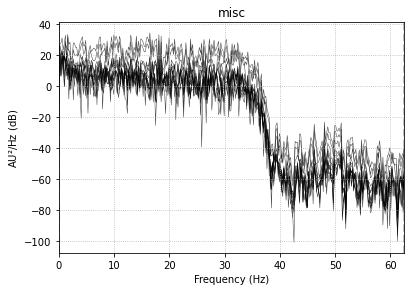

In [35]:
eeg_trial = mne.io.RawArray(eeg_trials[103].T, info, verbose=False)
fig = eeg_trial.plot_psd(picks=ch_names)

### Step 4 - Feature Extraction
We extract features via the [mne-features api](https://mne.tools/mne-features/api.html).
We can look at the params to see which features are being extracted:

In [124]:
params['features']

{'selected_channels': ['C03', 'C04'],
 'features': ['pow_freq_bands',
  'app_entropy',
  'decorr_time',
  'energy_freq_bands',
  'higuchi_fd',
  'hjorth_complexity',
  'hjorth_complexity_spect',
  'hjorth_mobility',
  'hjorth_mobility_spect',
  'hurst_exp',
  'katz_fd',
  'kurtosis',
  'line_length',
  'mean',
  'pow_freq_bands',
  'ptp_amp',
  'samp_entropy',
  'skewness',
  'spect_edge_freq',
  'spect_entropy',
  'spect_slope',
  'std',
  'svd_entropy',
  'svd_fisher_info',
  'teager_kaiser_energy',
  'variance',
  'wavelet_coef_energy',
  'zero_crossings'],
 'image_size': (32, 600),
 'pca': 50}


Here is a sample of the features extracted:

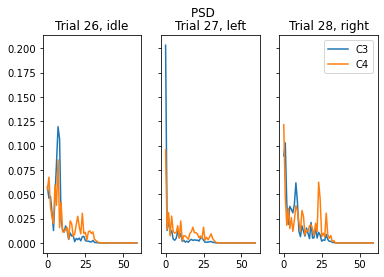

In [120]:
df = pd.read_csv('../data/evyatar/3/features.csv', header=None)
stimulus_vector = np.genfromtxt('../data/evyatar/3/stimulus_vectors.csv',dtype=int, delimiter=',')
num_columns = len(df.columns)
fig, axes = plt.subplots(1,3, sharey=True)
fig.suptitle("PSD ")
fig.set_facecolor('w')
for idx, trial_num in enumerate(range(26, 29)):
    df_c3 = df.loc[trial_num, :num_columns/2 - 1]
    df_c4 = df.loc[trial_num, num_columns/2:]
    axes[idx].plot(df_c3, label='C3')
    axes[idx].plot(df_c4.reset_index().drop(columns=['index']), label='C4')
    axes[idx].set_title('Trial {}, {}'.format(trial_num, params['experiment']['enumerate_stim'][stimulus_vector[trial_num]]))
plt.legend()
plt.show()

### Step 5 - Train and Test a Model

The next script is concentrates on train and test model.
The main function in this module is the `train()` function.
The function get 2 arguments - `mode` and `model_name`.

The `mode` argument decide how to treat the different days in the subject folder.
Because the the data was recorded on different days with different environmental
variables we expect it to be different. We can't train a model on the first day and
expect for good results on the other days. So we created 3 different modes
for splitting the data into train and test:

1. `same_day` - on the `same_day` mode the data will be split for each day
separately. Each day will have his own train and test data according to the
train ratio which can be found in the config file. Hence, the model will be train
on the data from the current day and also will be test on it.

1. `first_day` - on this procedure the model will be train only on the first day and will be
test on the other days.

1. `adjust` - on the adjust mode the model will be trained each day on
the first day with couple more data samples from the current day. In this mode
we using previous data in each day and there is no need to train model from sketch.

The second argument in the function, i.e., `model_name` represent the name of the ML model
which will be used to classify. Currently we implemented SVM, KNN and Random Forest models,
but every developer can easily add his desirable model to the function.

An example for using the `train()` function is:

```{python}
mi.assess_model.train(mode='same day', model='svm')
```

#### Results

We trained different type of models and test them on our EEG data.
We used only `same_day` mode in the `train()` function. The results can
be seen here:


In [ ]:
results = pd.read_csv('results.csv')
sns.set_style(style='whitegrid')
sns.catplot(x='Day', y='Accuracy', hue='Model', col='Subject', data=results, kind='bar')
plt.show()

# ADD SOME WORDS ABOUT THE RESULTS

## Part 2: Experiment with ResNet Features

As we was requested in the instructions we need to implement a different approach for one of
the above-mentioned steps. We chose to re-implement features extraction step. Over the first time
we used a classic approach in order to extract features from the EEG data to the ML model. These
classic approach required a domain knowledge in the data - which channels are more important
for MI classification, more common features for the classification problem and etc.
In the re-implementation part we want to implement feature extraction method which not demand any domain-knowledge
and to test the result of the model. We were constructed not to use any deep learning algorithm for
the model step, but hey, we can definitely use one for the feature extraction step!

We decided to use pre-trained Convolutional Neural Network (CNN) in order to extract
features from each EEG trial. The CNN consist on first on convolutional layers and then on fully-connected layers.
So, we used the pre-trained ResNet, which been trained on the 'imagenet' dataset, and use it
where `include_top=False`, i.e., we used only the output of the convolutional layers.
The ResNet input image size need to be at list `(32, 32)`. Since we got only 15 channels we needed to resize
the EEG data in order to fit the ResNet input shape. The initial EEG resize is the first hyperparameter.

Using a pooling layer we got from the ResNet a vector with 2048 features for each EEG trial.
Then we used a PCA algorithm for dimensionality reduction. The number of components
using the PCA is our second hyperparameter. Now we used it as our feature vector for the ML model.

All the hyperparameters we used can be found in the `config.yaml` configuration
file.

Now we used our `extract()` function to extract features using ResNet:

```{python}
mi.extract_features.extract(mode='cnn')
```

And the full pipeline using ResNet as feature extractor should look like:

```{python}
# Assuming you already record an experiment

mi.preprocess.preprocess()

mi.segment_data.segment_data()

mi.extract_features.extract(mode='cnn')

mi.assess_model.train('same day', 'svm')
```

Now let's look at the results of the ResNet performance using SVM for classification:

In [ ]:
results = pd.read_csv('results_cnn.csv')
sns.set_style(style='whitegrid')
sns.catplot(x='Day', y='Accuracy', hue='Model', col='Subject', data=results, kind='bar', legend=False)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# ADD HERE SOME WORDS ABOUT THE RESNET RESULTS